In [2]:
from scPreGAN.model.util import load_anndata
from thesis import DATA_PATH, SAVED_RESULTS_PATH
from scPreGAN import Model
from thesis.evaluation import ModelConfig
import scanpy as sc

In [3]:

pbmc_data = DATA_PATH / "pbmc/pbmc.h5ad"
pbmc = sc.read_h5ad(pbmc_data)

In [13]:
condition_key = 'condition'
condition = {
    'case': 'stimulated',
    'control': 'control'
}
cell_type_key = 'cell_type'
out_of_sample_prediction = True
target_cell_type= 'Dendritic'


adata_split, train_data = load_anndata(adata=pbmc,
                condition_key=condition_key,
                condition=condition,
                cell_type_key=cell_type_key,
                target_cell_type=target_cell_type
                )
control_adata, perturb_adata, case_adata = adata_split
control_pd, control_celltype_ohe_pd, perturb_pd, perturb_celltype_ohe_pd = train_data

cell_types = control_adata.obs[cell_type_key].unique().tolist()
batch = cell_types.index(target_cell_type)

: 

In [29]:
# create model
n_features = control_pd.shape[1]
n_classes = control_adata.obs[cell_type_key].unique().shape[0]
print(n_features, n_classes)


6998 7
Random Seed:  3060
Successfully created the model


In [ ]:
# training
from scPreGAN.model.scPreGAN import is_model_trained

model_config_pbmc = ModelConfig(
    model_name="scPreGAN",
    dataset_name="pbmc",
    experiment_name="",
    perturbation="ifn-b",
    cell_type_key="cell_type",
    root_path=SAVED_RESULTS_PATH
)

output_path = model_config_pbmc.get_batch_path(batch=batch)
tensorboard_path = model_config_pbmc.get_batch_log_path(batch=batch)

REFRESH = False
load_model = is_model_trained(output_path=output_path) and not REFRESH

model = Model(n_features=n_features, n_classes=n_classes, use_cuda=True)
model.train(train_data=train_data, output_path=output_path, load_model=load_model, tensorboard_path=tensorboard_path)

Random Seed:  3060
Successfully created the model
[100/20000] adv_loss: 0.0073  recon_loss: 0.0586 encoding_loss: 0.0032 G_loss: 0.0691 D_A_loss: -0.3298  D_B_loss: -0.1128
[200/20000] adv_loss: 0.0046  recon_loss: 0.0498 encoding_loss: 0.0008 G_loss: 0.0552 D_A_loss: -0.2988  D_B_loss: 0.0918
[300/20000] adv_loss: 0.0047  recon_loss: 0.0518 encoding_loss: 0.0007 G_loss: 0.0573 D_A_loss: 0.0081  D_B_loss: -0.1489
[400/20000] adv_loss: 0.0077  recon_loss: 0.0478 encoding_loss: 0.0004 G_loss: 0.0559 D_A_loss: -0.4813  D_B_loss: -0.3440
[500/20000] adv_loss: 0.0069  recon_loss: 0.0500 encoding_loss: 0.0005 G_loss: 0.0573 D_A_loss: -0.6913  D_B_loss: -0.4302
[600/20000] adv_loss: 0.0084  recon_loss: 0.0465 encoding_loss: 0.0006 G_loss: 0.0555 D_A_loss: -0.4506  D_B_loss: -0.4338
[700/20000] adv_loss: 0.0090  recon_loss: 0.0475 encoding_loss: 0.0007 G_loss: 0.0571 D_A_loss: -0.8580  D_B_loss: -0.5385
[800/20000] adv_loss: 0.0102  recon_loss: 0.0494 encoding_loss: 0.0006 G_loss: 0.0602 D_A_l

In [10]:
# predicting
control_test_adata = control_adata[control_adata.obs["cell_type"] == target_cell_type]
perturb_test_adata = perturb_adata[perturb_adata.obs["cell_type"] == target_cell_type]


In [32]:
pred_perturbed_adata = model.predict(control_adata=control_test_adata,
                   cell_type_key=cell_type_key,
                   condition_key=condition_key)
pred_perturbed_adata

Using CUDA for evaluation
Predicting data finished


AnnData object with n_obs × n_vars = 670 × 6998
    obs: 'condition', 'cell_type'

In [10]:
perturb_adata.obs.groupby(['condition', 'cell_type']).size()

condition   cell_type  
stimulated  CD4T           3483
            CD14+Mono       698
            B              1105
            CD8T            594
            NK              733
            FCGR3A+Mono    2790
            Dendritic       522
dtype: int64

In [11]:
control_adata.obs.groupby(['condition', 'cell_type']).size()

condition  cell_type  
control    CD4T           2715
           CD14+Mono      2184
           B               928
           CD8T            643
           NK              571
           FCGR3A+Mono    1232
           Dendritic       670
dtype: int64

In [12]:
case_adata.obs.groupby(['condition', 'cell_type']).size()

condition   cell_type  
stimulated  CD4T           3483
            CD14+Mono       698
            B              1105
            CD8T            594
            NK              733
            FCGR3A+Mono    2790
dtype: int64

saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/batch1/dotplot.pdf
Evaluation figs saved to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/batch1/evaluation.pdf
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/batch1/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/batch1/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/batch1/metrics.csv


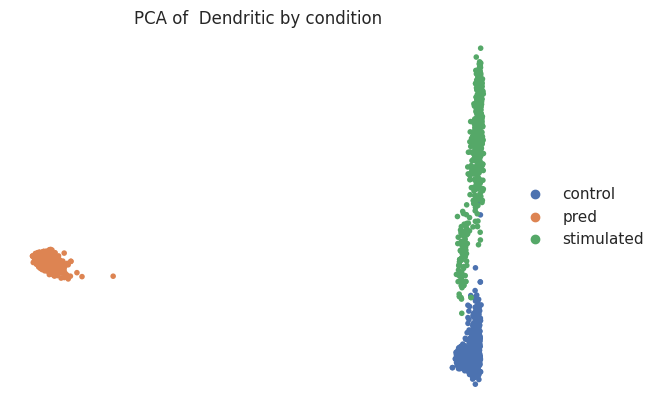

In [33]:
from thesis.evaluation import evaluation_out_of_sample


evaluation_out_of_sample(
    model_config=model_config_pbmc,
    input=control_test_adata,
    ground_truth=perturb_test_adata,
    predicted=pred_perturbed_adata,
    output_path=model_config_pbmc.get_batch_path(batch),
    save_plots=True,
    append_metrics=False
    )


Attempt to use the script from the reproducibility to check differences with the provided scPreGAN. For example, in the reproducibility training script there is `calc_gradient_penalty`, that doesn't exist in the scPreGAN repo.

In [7]:
from scPreGAN.reproducibility.scPreGAN_OOD_prediction import train_and_predict


model_config_reproducible_pbmc = ModelConfig(
    model_name="scPreGAN",
    dataset_name="pbmc",
    experiment_name="reproducible",
    perturbation="ifn-b",
    cell_type_key="cell_type",
    root_path=SAVED_RESULTS_PATH
)

output_path_reproducible = model_config_reproducible_pbmc.get_batch_path(batch=batch)

opt = {
    'cuda': True,
    'dataset': pbmc,
    'checkpoint_dir': None,
    'condition_key': 'condition',
    'condition': {"case": "stimulated", "control": "control"},
    'cell_type_key': 'cell_type',
    'prediction_type': 'Dendritic',
    'out_sample_prediction': True,
    'manual_seed': 3060,
    'data_name': 'pbmc',
    'model_name': 'pbmc_OOD',
    'outf': output_path_reproducible,
    'validation': False,
    'valid_dataPath': None,
    'use_sn': True,
    'use_wgan_div': True,
    'gan_loss': 'wgan'
}


config = {
    "batch_size": 64,
    "lambda_adv": 0.001,
    "lambda_encoding": 0.1,
    "lambda_l1_reg": 0,
    "lambda_recon": 1,
    "lambta_gp": 1,
    "lr_disc": 0.001,
    "lr_e": 0.0001,
    "lr_g": 0.001,
    "min_hidden_size": 256,
    "niter": 20_000,
    "z_dim": 16
}


pred_perturbed_reproducible_adata = train_and_predict(opt=opt, config=config, tensorboard_path=model_config_reproducible_pbmc.get_batch_log_path(batch))



Random Seed:  3060
No validation.
feature length:  6998
Finished Training
Using CUDA for evaluation


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ifn-b/dosage0/reproducible/batch1/dotplot.pdf
Evaluation figs saved to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ifn-b/dosage0/reproducible/batch1/evaluation.pdf
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ifn-b/dosage0/reproducible/batch1/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ifn-b/dosage0/reproducible/batch1/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ifn-b/dosage0/reproducible/batch1/metrics.csv


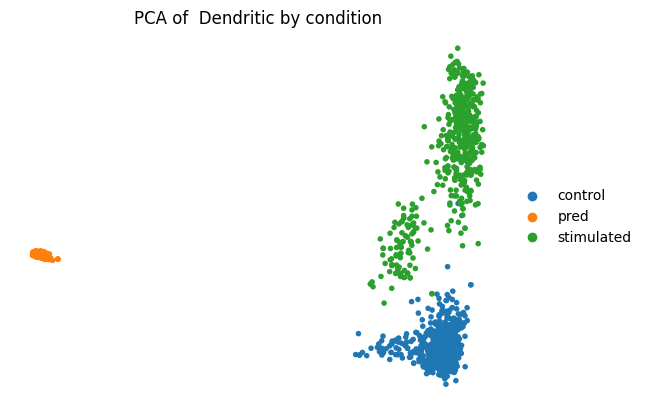

In [11]:
# 
from thesis.evaluation import evaluation_out_of_sample


evaluation_out_of_sample(
    model_config=model_config_reproducible_pbmc,
    input=control_test_adata,
    ground_truth=perturb_test_adata,
    predicted=pred_perturbed_reproducible_adata,
    output_path=model_config_reproducible_pbmc.get_batch_path(batch),
    save_plots=True,
    append_metrics=False
    )
